In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import torch as pt
from models.simple import FeatureExtractor, Comparitor, PUTransformer, PerceptualLossFeatureExtractor,DimTransformer
from models.common import PUPieApp, PerceptLossNet,PUPieAppEndToEnd
from loader.dataset import ImageLoader, image2patches_det
%matplotlib inline

# Set common variables

In [2]:
# Path to reference and distorted iamges
ref_path = './example_images/ldr/i06.bmp'
dist_path ='./example_images/ldr/i06_15_5.bmp'
dynamic_range = 'ldr'


# Parameters of the display model (Assuming peak and lack level of a display on which LDR image is shown).
# Set to 100 and 0.5 if unsure. The parameter is not used for HDR images as these are given in luminance values.
top_l = 100
bot_l = 0.5

# The quality assessment model operates on 64x64 patches sampled on a regular grid. 
# The shift specifies the window shift for sampling the patchs. The smaller the shift the more accurate the model is.
stride = 16
saved_state_model = '../net_only.pt'
state = pt.load(saved_state_model, map_location='cpu')
loader = ImageLoader()

def read_convert_pt_image(image_path):
    image = imageio.imread(image_path)
    image = pt.from_numpy(imageio.core.asarray(image))
    image = image.permute(2,0,1)
    return image

# Run perceptual loss network (VGG style)


In [6]:
# Create the network 
net = PerceptLossNet(PUTransformer(), PerceptualLossFeatureExtractor())
# Initialise the weights
net.extractor.load_state_dict(state['extractor'])
# Switch of the training mode
net.eval()

# Read images and convert them into the pytorch tensorc with dimensions NCHW
image_ref = read_convert_pt_image(ref_path)
image_dis = read_convert_pt_image(dist_path)
image_ref = image_ref.unsqueeze(0)
image_dis = image_dis.unsqueeze(0)

# Run the network without recorcding the gradient
with pt.no_grad():
    feature1r, feature2r, feature3r, feature4r, feature5r = net(image_ref,im_type=dynamic_range, lum_top=top_l, lum_bottom=bot_l)
    feature1d, feature2d, feature3d, feature4d, feature5d = net(image_dis,im_type=dynamic_range, lum_top=top_l, lum_bottom=bot_l)



# Run the PUPieApp
The network takes 64x64 image patches. It applies the display model, PU transform and normalises every patch between 0 and 1 internally.

The network takes as input image patches, dynamic range and top and bottom luminance of the display the image is shown on. If the image is an hdr image, the networks needs no top/bottom luminance parameters.

In [7]:
# Read images and split them into patches (note: no processing is applied). 
image_ref = read_convert_pt_image(ref_path)
image_dis = read_convert_pt_image(dist_path)

ref_patches, img_patches, weights = image2patches_det(image_ref,image_dis,64,stride)

# Create and load the model
net = PUPieApp(PUTransformer(), FeatureExtractor(), Comparitor())
net.extractor.load_state_dict(state['extractor'])
net.comparitor.load_state_dict(state['comparitor'])
net.eval()


# Run the network with no gradient
with pt.no_grad():
    score, per_patch_score, per_patch_weight  = net(ref_patches, img_patches,im_type=dynamic_range, lum_top=top_l, lum_bottom=bot_l)

/Users/aliaksei/Documents/PUPieApp/loader/dataset.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reference[:,h:h+patch_size, w:w+patch_size]))
/Users/aliaksei/Documents/PUPieApp/loader/dataset.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image[:,h:h+patch_size, w:w+patch_size]))


# Visualise what areas of the image the network sees the distortions in

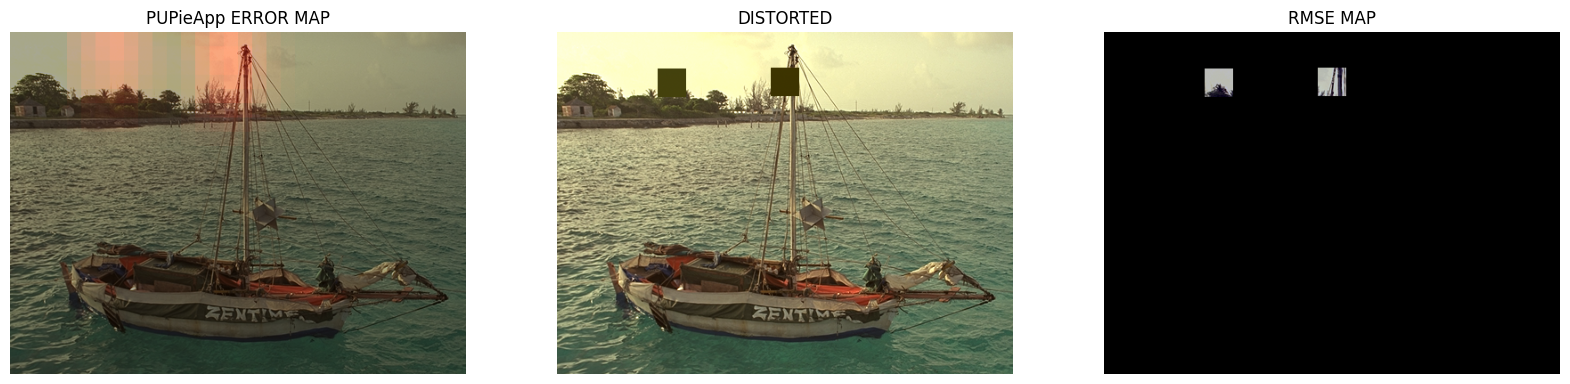

In [13]:
# Re-normalise the weight and the score between 0 and 1
pp_score = np.squeeze(per_patch_score.cpu().numpy())
pp_weight = np.squeeze(per_patch_weight.cpu().numpy())
pp_weight_n = (pp_weight-np.min(pp_weight))/np.max(pp_weight -np.min(pp_weight))
pp_score_n =  1-(pp_score-np.min(pp_score))/np.max((pp_score-np.min(pp_score)))

# Assemble the image from the image patches and create an error map of the image patche scores, weighted by the patch weight
image_ref,  error_map = loader.create_error_map(ref_patches.numpy(),weights,pp_score_n,pp_weight_n,shift_patch=stride)
image_dist, error_map = loader.create_error_map(img_patches.numpy(),weights,pp_score_n,pp_weight_n,shift_patch=stride)

# Set up the error map - blend it with the image: blend - blending parameter: how much of an image and how much of the
# error map is displayed.
blend = 0.8
error_map[1:3,:,:] = 0.0  
PUPieApp_blended_error_map = np.add(error_map*2*blend, (1-blend)*image_ref/255*3)

plt.figure(figsize=(20, 6), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.imshow(np.transpose(PUPieApp_blended_error_map/PUPieApp_blended_error_map.max(),(1,2,0)));
plt.axis('off')
plt.title('PUPieApp ERROR MAP')

plt.subplot(132)
plt.imshow(np.transpose(image_dist/image_dist.max(),(1,2,0)));
plt.axis('off')
plt.title('DISTORTED')

plt.subplot(133)
plt.imshow(np.transpose(np.sqrt((image_ref/image_ref.max()-image_dist/image_dist.max())**2),(1,2,0)))
plt.axis('off')
plt.title('RMSE MAP')
plt.savefig("example_error_map_pupieapp.png", bbox_inches='tight')

# Full end-to-end loss function

In [5]:
# Read images and split them into patches (note: no processing is applied). 
image_ref = read_convert_pt_image(ref_path)
image_dis = read_convert_pt_image(dist_path)
image_ref = image_ref.unsqueeze(0)
image_dis = image_dis.unsqueeze(0)


# Create and load the model
net = PUPieAppEndToEnd(PUTransformer(),DimTransformer(), FeatureExtractor(), Comparitor())
net.extractor.load_state_dict(state['extractor'])
net.comparitor.load_state_dict(state['comparitor'])
net.eval();

# Run the network with no gradient
with pt.no_grad():
    score = net(image_ref, image_dis,im_type=dynamic_range, lum_top=top_l, lum_bottom=bot_l,stride = 16)